In [1]:
# importing
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

img_height = 180
img_width = 180
batch_size = 20
data_dir = "Data"

In [2]:
# finding training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  "Data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 702 files belonging to 31 classes.
Using 562 files for training.


In [3]:
# set up validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  "Data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 702 files belonging to 31 classes.
Using 140 files for validation.


In [4]:
# making sure class names are right
class_names = train_ds.class_names
print(class_names)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'Arrow Down Blue', 'Arrow Down Green', 'Arrow Down Red', 'Arrow Down White', 'Arrow Left Blue', 'Arrow Left Green', 'Arrow Left Red', 'Arrow Left White', 'Arrow Right Blue', 'Arrow Right Green', 'Arrow Right Red', 'Arrow Right White', 'Arrow Up Blue', 'Arrow Up Green', 'Arrow Up Red', 'Arrow Up White', 'Circle', 'Letter A', 'Letter B', 'Letter C', 'Letter D', 'Letter E', 'Letter F', 'Letter G', 'Letter H', 'Letter S', 'Letter T', 'Letter U', 'Letter V', 'Letter W', 'Letter X', 'Letter Y', 'Letter Z', 'Marker']


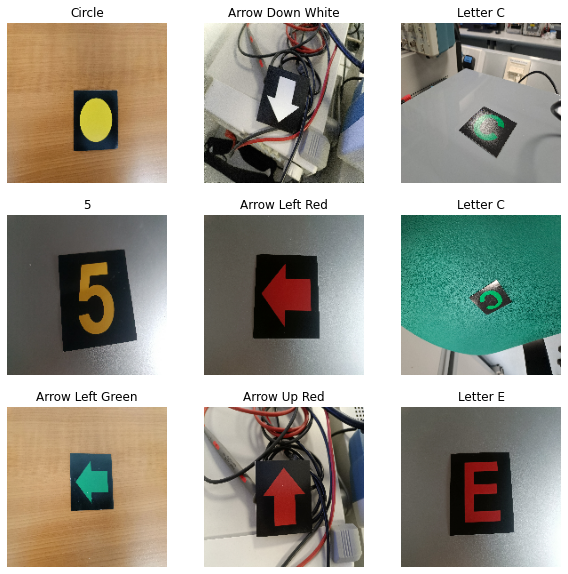

In [5]:
# displaying first few images as reference
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# idk what this does
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(20, 180, 180, 3)
(20,)


In [7]:
# tuning tensorflow
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# pre-processing
normalization_layer = layers.Rescaling(1./255)

In [9]:
# pre-processing
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
# setting up model
num_classes = len(class_names)

power = 4

print(2**power)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(2**power, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2**(power+2), 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2**(power+4), 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2**(power+6), 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2**(power+4), 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(2**(power+2), 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

16


In [11]:
# pre-processing for rotation and zoom of pictures
data_augmentation = keras.Sequential(
  [
    # layers.RandomFlip("horizontal",
    #                   input_shape=(img_height,
    #                               img_width,
    #                               3)),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.6),
  ]
)

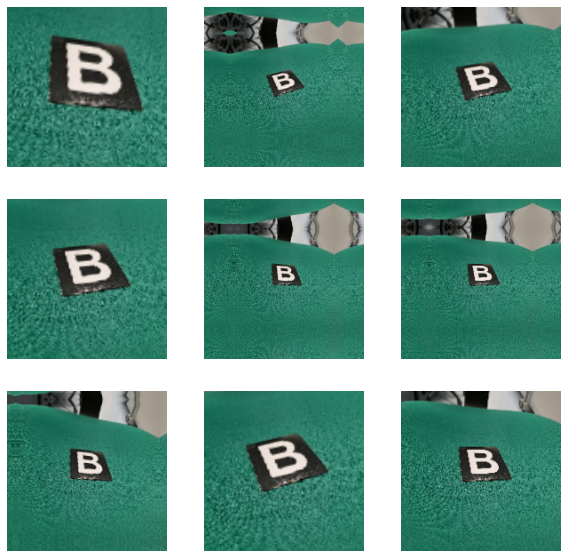

In [12]:
# displaying pre-processed images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
# creating the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# it's... a summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 256)       0

In [18]:
# training!
epochs = 70
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/70
39/39 [==============================] - 39s 1s/step - loss: 5.7488e-05 - accuracy: 1.0000 - val_loss: 3.0771 - val_accuracy: 0.6907
Epoch 2/70
39/39 [==============================] - 44s 1s/step - loss: 3.8345e-05 - accuracy: 1.0000 - val_loss: 3.2340 - val_accuracy: 0.6753
Epoch 3/70
39/39 [==============================] - 46s 1s/step - loss: 2.8258e-05 - accuracy: 1.0000 - val_loss: 3.3166 - val_accuracy: 0.6649
Epoch 4/70
39/39 [==============================] - 46s 1s/step - loss: 2.2204e-05 - accuracy: 1.0000 - val_loss: 3.3604 - val_accuracy: 0.6753
Epoch 5/70
39/39 [==============================] - 46s 1s/step - loss: 1.8530e-05 - accuracy: 1.0000 - val_loss: 3.3838 - val_accuracy: 0.6753
Epoch 6/70
39/39 [==============================] - 46s 1s/step - loss: 1.6203e-05 - accuracy: 1.0000 - val_loss: 3.4189 - val_accuracy: 0.6753
Epoch 7/70
39/39 [==============================] - 46s 1s/step - loss: 1.4506e-05 - accuracy: 1.0000 - val_loss: 3.4864 - val_accuracy:

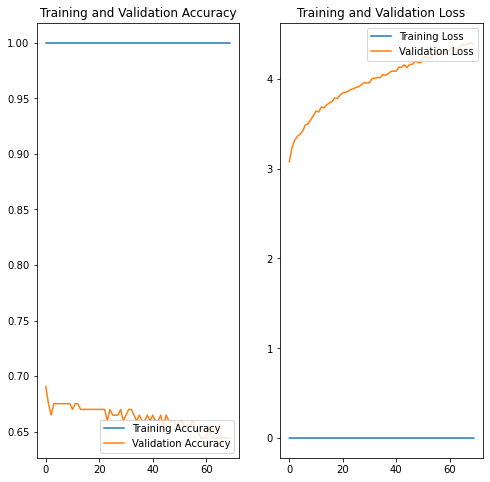

In [19]:
# displaying how accurate it is
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# loading in an image to test the accuracy

# if you want to try your own image or something just
# change the validation_path variable
validation_path = "D:\OneDrive\Pictures\Camera Roll\WIN_20230127_10_22_57_Pro.jpg"

img = tf.keras.utils.load_img(
    validation_path,
    target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Letter F with a 98.87 percent confidence.


In [ ]:
# saving the model for later conversion
tf.keras.Model.save(model, "D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Keras_Model")

In [ ]:
# Convert the model from saved tensor model to tensorflow lite model
converter = tf.lite.TFLiteConverter.from_saved_model("D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Keras_Model") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# creating interpreter object to use tflite model
interpreter = tf.lite.Interpreter(model_path="D:\OneDrive - Nanyang Technological University\Year 2 Sem 2\SC2079 MDP\Tensor_Testing\Tensorflow Testing\model.tflite")
interpreter.get_signature_list()

In [ ]:
# making use of the tflite model
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
# using the tflite model
predictions_lite = classify_lite(rescaling_1_input=img_array)['dense_1']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
# testing the tflite model for accuracy
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)